In [2]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from scipy.interpolate import UnivariateSpline, interp1d
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.stats.libqsturng import psturng
import scipy.stats as stats

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures

# Make a folder to store cleaned up data frames for more advanced statistical analysis in R.
# This is only necessary because exact p values were required by the journal, whereas the
# psturng in statsmodels.stats.libqsturng was bound by 0.001 and 0.9.
# Practically, nobody really cares about exact p values when p < 0.001 and p > 0.9, but got to get it when asked.
!mkdir ../data_cleaned


mkdir: ../jupyter_figures: File exists
mkdir: ../data_cleaned: File exists


In [3]:
def header(f, N=10):
    '''Print out the first N lines of a file
    '''
    with open(f) as myfile:
        head = [next(myfile).strip() for x in range(N)]
    return '\n'.join(head)

def getCountDF(codingFile, countFile):
    '''Read in data from corresponding filename coding and
    counting files, merge the data by scrambled filenames,
    and returns the merged data frame.
    '''
    dfCode = pd.read_csv(codingFile, header=0, sep='\t')
    dfCode.columns = ['file_name', 'scrambled_file_name']
    dfCount0 = pd.read_csv(countFile, header=0, sep='\t')
    dfCount0.columns = ['scrambled_file_name', 'counts']
    dfCount = dfCode.merge(dfCount0, on = 'scrambled_file_name')
    return dfCount

def getCountDFbyPrefix(datasetPrefix, datasetFolder=None):
    '''A convenience function of getCountDF.
        Use pattern match to identify the corresponding pair
    of filename coding and counting files, then call getCountDF
    to obtain the merged data frame.
    '''
    if datasetFolder is None:
        # This is the default folder storing most bud count files
        datasetFolder = '../data/Kaz-bud-count-files/'
    # Identify the corresponding pair of filename coding and counting files
    codingFiles = glob.glob( datasetFolder + datasetPrefix + '*fileNameRecord.txt')
    countFiles = glob.glob( datasetFolder + datasetPrefix + '*budCount.txt')

    # There should be only one coding file for each data set
    codingFile = codingFiles[0]

    # There could be multiple count files for each data set,
    # which is because sometimes Kaz counts for several times
    # to check for counting consistenty. Take the last one.
    countFiles.sort()
    countFile = countFiles[-1]

    # print(header(codingFile))
    # print(header(countFile))

    df = getCountDF(codingFile, countFile)
    
    return df

def tukeyTest(data, groups, alpha=0.05):
    '''Perform pairwise Tukey test for the data by groups
    '''
    # pairwise comparisons using Tukey's test, calculating p-values
    res = pairwise_tukeyhsd(data, groups, alpha)
    print('Summary of test:\n', res)
    # print(dir(results))# prints out all attributes of an object
    pVal = psturng(np.abs(res.meandiffs / res.std_pairs), len(res.groupsunique), res.df_total)
    print('p values of all pair-wise tests:\n', pVal)

    return res


In [145]:
def plotCountBar(groups, counts, outputFigPath,
                 yMax=None, yTicks=None,
                 bar_width=0.7,
                 fig_width=0.7, fig_height=0.9):
    '''plot bar plot of bud counting data, save .svg as outputFigPath
    
    Note: error bar here is 95% confidence interval by bootstrapping
    '''
    
    fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    sns.barplot(groups, counts,
                color=".7", # This a nicer looking lighter gray to my own taste
                errwidth=.7, errcolor="k", capsize=.2, ci=95)

    if yMax == None:
        yMax = int(max(counts)/5 + 1) * 5
    if yTicks == None:
        yTicks = [10*i for i in range(int(max(counts)/10 + 1))]
    
    plt.ylim(0, yMax)
    plt.yticks(yTicks)
    
    plt.xlabel("Groups")
    plt.ylabel("Buds per spheroid")
    
    # Narrow the bar width
    change_bar_width(ax, bar_width)
    
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)

    plt.savefig(outputFigPath)
    
    return ax

def change_bar_width(ax, new_value):
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [4]:
# Read in the raw data sets to plot
# These are the two experiments with DMSO or ABA treated control or E-cad down spheroids

datasetPrefix = "190926"
df1 = getCountDFbyPrefix(datasetPrefix)

datasetPrefix = "191008"
df2 = getCountDFbyPrefix(datasetPrefix)

# Inspect raw data
# plt.plot(df1.counts)
# plt.plot(df2.counts)

In [5]:
# Annotate data sets with the experimental conditions

# datasetPrefix: "190926"
# 88 spheroids in wells A1-H11 (last column not accessible for automated imaging)
#
# Plate layout:
# A1-A6: sg-control, DMSO, ***no MG***
# A7-A11: sg-control, ABA, ***no MG***
# B1-B6: sg-control, DMSO, MG
# B7-B11: sg-control, ABA, MG
# C1-C6: sg-control mixed with sg1-Ecad (4:1), DMSO, ***no MG***
# C7-C11: sg-control mixed with sg1-Ecad (4:1), ABA, ***no MG***
# D1-D11: sg-control mixed with sg1-Ecad (4:1), DMSO, MG
# E1-G11: sg-control mixed with sg1-Ecad (4:1), ABA, MG
# H1-H11: sg-control mixed with ***sg2-Ecad*** (4:1), ABA, MG
#
# This set of files contains 6, 5, 11, 33 and 11 samples for groups 1-4 and 6:
# Group 1: sg-Control only, DMSO, MG
# Group 2: sg-Control only, ABA, MG
# Group 3: sg-Control mixed with sg1-Ecad (4:1), DMSO, MG
# Group 4: sg-Control mixed with sg1-Ecad (4:1), ABA, MG
# Group 6: sg-Control mixed with sg2-Ecad (4:1), ABA, MG
groups1 = ["zzz_ignore"]*11 + ["1"]*6 + ["2"]*5 + \
            ["zzz_ignore"]*11 + ["3"]*11 + ["4"]*33 + ["6"]*11

# print(groups1)


# datasetPrefix: "191008"
# 73 spheroids in wells A1-H11 (last column not accessible for automated imaging)
# In addition, B1-B3, D1-D6 and G1-G6 were left out when imaging for fluorescence
# because they were treated with blebbistatin and were photo-sensitive.
# Y: B4-B6, E1-E6 and H1-H6.
#
# Plate layout:
# A1-A3: sg-control, DMSO, ***no MG***
# A4-A6: sg-control, ABA, ***no MG*** 
# A7-A11: sg-control, DMSO, MG
# B4-B6: sg-control, ABA, MG, ***Y27632***
# B7-B11: sg-control, ABA, MG
# C1-C3: sg-control mixed with sg1-Ecad (4:1), DMSO, ***no MG***
# C4-C6: sg-control mixed with sg1-Ecad (4:1), ABA, ***no MG***
# C7-C11: sg-control mixed with sg1-Ecad (4:1), DMSO, MG
# D7-D11 & E7-E11: sg-control mixed with sg1-Ecad (4:1), ABA, MG
# E1-E6: sg-control mixed with sg1-Ecad (4:1), ABA, MG, ***Y27632***
# F1-F3: sg-control mixed with sg2-Ecad (4:1), DMSO, ***no MG***
# F4-F6: sg-control mixed with sg2-Ecad (4:1), ABA, ***no MG***
# F7-F11: sg-control mixed with sg2-Ecad (4:1), DMSO, MG
# G7-G11 & H7-H11: sg-control mixed with sg2-Ecad (4:1), ABA, MG
# H1-H6: sg-control mixed with sg2-Ecad (4:1), ABA, MG, ***Y27632***
#
# To sum the ones I need to plot:
# Group 1: sg-Control only, DMSO, MG
# Group 2: sg-Control only, ABA, MG
# Group 3: sg-Control mixed with sg1-Ecad (4:1), DMSO, MG
# Group 4: sg-Control mixed with sg1-Ecad (4:1), ABA, MG
# Group 5: sg-Control mixed with sg2-Ecad (4:1), DMSO, MG
# Group 6: sg-Control mixed with sg2-Ecad (4:1), ABA, MG
# Other samples will be annotated "zzz_ignore" for the purpose of this plotting
groups2 = ["zzz_ignore"]*6 + ["1"]*5 + ["zzz_ignore"]*3 + ["2"]*5 + \
        ["zzz_ignore"]*6 + ["3"]*5 + ["4"]*5 + ["zzz_ignore"]*6 + ["4"]*5 + \
        ["zzz_ignore"]*6 + ["5"]*5 + ["6"]*5 + ["zzz_ignore"]*6 + ["6"]*5


In [6]:
df = pd.concat([df1,df2])
df["groups"] = groups1 + groups2
groupsToKeep = ["1", "2", "3", "4"]
# print(df1and2.groups)
dfToPlot = df.loc[df['groups'].isin(groupsToKeep)]

# Pass to general df variable to ease the plotting
df = dfToPlot
df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + '190926-191008-dataset-groups1-4-bud-count.csv')
# Inspect raw data if curious about how they look
# sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      2  -0.3455   0.9 -7.3301  6.6392  False
     1      3   -0.233   0.9 -6.4942  6.0282  False
     1      4  15.9894 0.001 10.5881 21.3907   True
     2      3   0.1125   0.9 -6.3316  6.5566  False
     2      4  16.3349 0.001 10.7226 21.9471   True
     3      4  16.2224 0.001 11.5411 20.9037   True
---------------------------------------------------
p values of all pair-wise tests:
 [0.9   0.9   0.001 0.9   0.001 0.001]


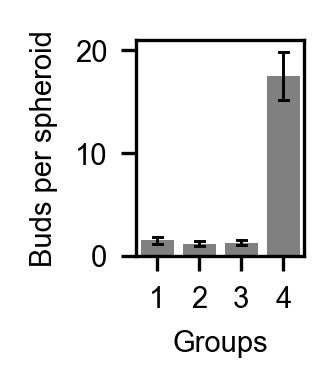

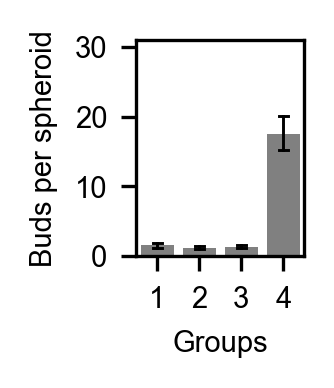

In [7]:
outputPrefix = "190916-191008-6dpt-combined-4groups"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count-taller-bar.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=21, yTicks=[0,10,20], fig_width=0.7, fig_height=0.9)
outputPrefix = "190916-191008-6dpt-combined-4groups"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count-shorter-bar.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=31, yTicks=[0,10,20,30], fig_width=0.7, fig_height=0.9)


In [8]:
df = pd.concat([df1,df2])
df["groups"] = groups1 + groups2
groupsToKeep = ["1", "2", "3", "4", "5", "6"]
# print(df1and2.groups)
dfToPlot = df.loc[df['groups'].isin(groupsToKeep)]

# Pass to general df variable to ease the plotting
df = dfToPlot
df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + '190926-191008-dataset-groups1-6-bud-count.csv')

# Inspect raw data if curious about how they look
# sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2  -0.3455    0.9  -8.3623  7.6714  False
     1      3   -0.233    0.9  -7.4195  6.9536  False
     1      4  15.9894  0.001   9.7899  22.189   True
     1      5   2.4545    0.9  -7.4417 12.3508  False
     1      6  18.4069  0.001  11.5779  25.236   True
     2      3   0.1125    0.9  -7.2839  7.5089  False
     2      4  16.3349  0.001   9.8932 22.7765   True
     2      5      2.8    0.9  -7.2497 12.8497  False
     2      6  18.7524  0.001  11.7028  25.802   True
     3      4  16.2224  0.001  10.8493 21.5955   True
     3      5   2.6875    0.9  -6.7131 12.0881  False
     3      6  18.6399  0.001  12.5512 24.7286   True
     4      5 -13.5349  0.001 -22.2044 -4.8654   True
     4      6   2.4175 0.6793  -2.4672  7.3022  False
     5      6  15.9524  0.001   6.8221 25.0827   True
----------

In [9]:
df.counts[df.groups=='5']

52    6
53    4
54    3
55    4
56    3
Name: counts, dtype: int64

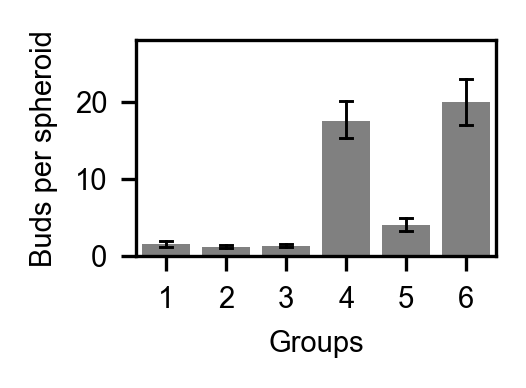

In [10]:
outputPrefix = "190916-191008-6dpt-combined-6groups"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=28, yTicks=[0,10,20], fig_width=1.5, fig_height=0.9)


In [11]:
# Read in the data and put into a data frame
datasetPrefix = "20191219-6dpt-zStack-integrin-activation"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin activation test, only Matrigel was added (no ABA)
# Integrin activation was done by adding 50 uM MnCl2, 10 ug/mL TS2/16 or both
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-C6: sg-Control only, 50 uM MnCl2
# Group 3, C7-C11: sg-Control only, 10 ug/mL TS2/16
# Group 4, D2-D11: sg-Control only, 50 uM MnCl2 and 10 ug/mL TS2/16
# Group 5, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 6, F2-F6: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2
# Group 7, F7-F11: sg-Control mixed with sg2-Ecad (4:1), 10 ug/mL TS2/16
# Group 8, G2-G11: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2 and 10 ug/mL TS2/16

groups = ["1"]*10 + ["2"]*5 + ["3"]*5 + ["4"]*10 +\
            ["5"]*10 + ["6"]*5 + ["7"]*5 + ["8"]*10
df["groups"] = groups


# # Inspect raw data if curious about how they look
# sns.swarmplot(df.groups, df.counts)

# # Perform a Tukey test across groups
# tukeyTest(df.counts, df.groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     1      5      4.0 0.0077 1.0092  6.9908   True
     1      6     10.2  0.001 6.5371 13.8629   True
     5      6      6.2  0.001 2.5371  9.8629   True
---------------------------------------------------
p values of all pair-wise tests:
 [0.00765765 0.001      0.001     ]


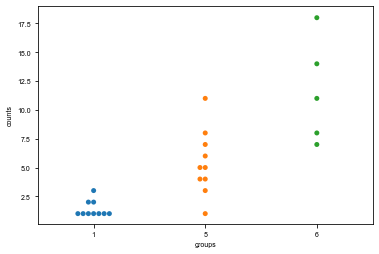

In [12]:
groupsToKeep = ["1", "5", "6"]
dfKeep = df.loc[df['groups'].isin(groupsToKeep)]

# Use general df variable to ease the plotting
df = dfKeep
df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + datasetPrefix + '-bud-count.csv')

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


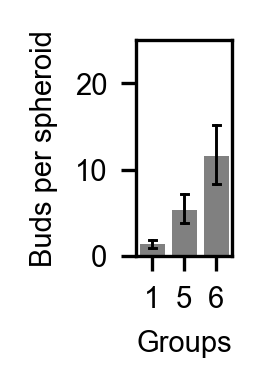

In [13]:
# Plot the bar graph to put in figures
outputPrefix = "191219-6dpt-integrin-activation"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=25, yTicks=[0,10,20], fig_width=0.4, fig_height=0.9)


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     1      2     -0.6   0.9  -3.6569   2.4569  False
     1      3   -19.75 0.001 -22.3973 -17.1027   True
     1      4    -19.9 0.001 -22.5473 -17.2527   True
     2      3   -19.15 0.001 -21.7973 -16.5027   True
     2      4    -19.3 0.001 -21.9473 -16.6527   True
     3      4    -0.15   0.9  -2.3115   2.0115  False
-----------------------------------------------------
p values of all pair-wise tests:
 [0.9   0.001 0.001 0.001 0.001 0.9  ]


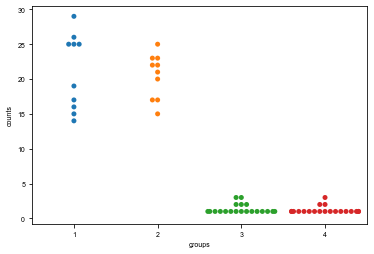

In [14]:
# Read in the data and put into a data frame
datasetPrefix = "20191219-6dpt-zStack-D193-D267-D301-D2"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin co-repression, all spheroids were treated with Matrigel and ABA
#
# Group 1, B2-B11: sg-control mixed with sg1-Ecad (1:1)
# Group 2, C2-C11: sg-Itgb1 mixed with sg1-Ecad (1:1)
# Group 3, D2-E11: sg-control mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Group 4, F2-G11: sg-Itgb1 mixed with sg1-Ecad/sg-Itgb1 (1:1)
groups = ["1"]*10 + ["2"]*10 + ["3"]*20 + ["4"]*20
df["groups"] = groups

df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + datasetPrefix + '-bud-count.csv')

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


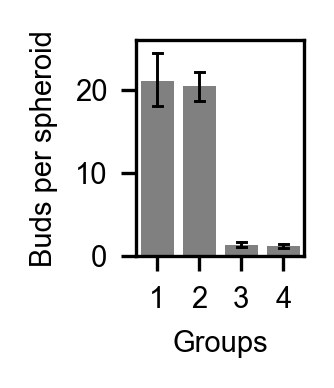

In [15]:
# Plot the bar graph to put in figures
outputPrefix = "191219-6dpt-D193-D267-D301-D2-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=26, yTicks=[0,10,20], fig_width=0.7, fig_height=0.9)


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  -4.8889 0.0058  -8.6328   -1.145   True
     1      3 -30.1056  0.001 -33.6696 -26.5415   True
     1      4 -30.7556  0.001 -34.8354 -26.6757   True
     2      3 -25.2167  0.001 -28.2496 -22.1838   True
     2      4 -25.8667  0.001 -29.4917 -22.2416   True
     3      4    -0.65    0.9   -4.089    2.789  False
------------------------------------------------------
p values of all pair-wise tests:
 [0.00576642 0.001      0.001      0.001      0.001      0.9       ]


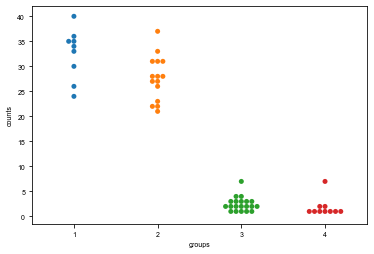

In [16]:
# Read in the data and put into a data frame
datasetPrefix = "20191224-6dpt-zStack-D193-D267-D301-D2-integrin-co-modulation-repeat"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# The layout of this data set is straightforward.
# For integrin co-repression, all spheroids were treated with Matrigel and ABA
#
# Group 1, B2-B11: sg-control mixed with sg1-Ecad (1:1)
# Group 2, C2-D11: sg-Itgb1 mixed with sg1-Ecad (1:1)
# Group 3, E2-F11: sg-control mixed with sg1-Ecad/sg-Itgb1 (1:1)
# Group 4, G2-G11: sg-Itgb1 mixed with sg1-Ecad/sg-Itgb1 (1:1)
# ***Note: B4, D2, D6, D7, D9 and D10 images were off-center or off-focus,
# so they were removed for segmentation
groups = ["1"]*9 + ["2"]*15 + ["3"]*20 + ["4"]*10
df["groups"] = groups

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


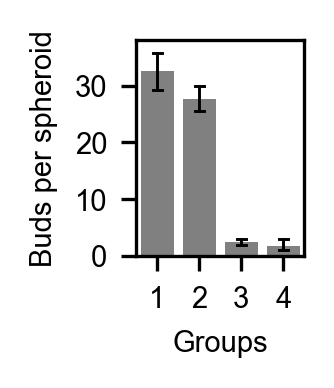

In [17]:
# Plot the bar graph to put in figures
outputPrefix = "191224-6dpt-D193-D267-D301-D2-"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=38, yTicks=[0,10,20,30], fig_width=0.7, fig_height=0.9)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2     -0.1    0.9  -4.439   4.239  False
     1      3      4.6  0.083 -0.4102  9.6102  False
     1      4     11.7  0.001   7.361  16.039   True
     2      3      4.7 0.0289   0.361   9.039   True
     2      4     11.8  0.001  8.2572 15.3428   True
     3      4      7.1  0.001   2.761  11.439   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.08295638 0.001      0.02885341 0.001      0.001     ]


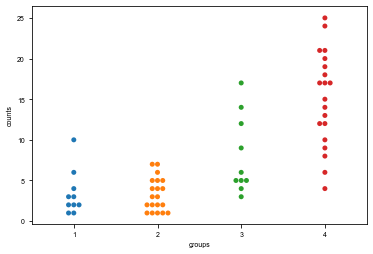

In [18]:
# Read in the data and put into a data frame
datasetPrefix = "20200120-6dpt-integrin-activation-MnCl2"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# The layout of this data set is straightforward.
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-D11: sg-Control only, 50 uM MnCl2
# Group 3, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 4, F2-G6: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2

groups = ["1"]*10 + ["2"]*20 + ["3"]*10 + ["4"]*20
df["groups"] = groups

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      3      4.6 0.1128 -0.8564 10.0564  False
     1      4     11.7  0.001  6.9746 16.4254   True
     3      4      7.1 0.0022  2.3746 11.8254   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.11279151 0.001      0.00215368]


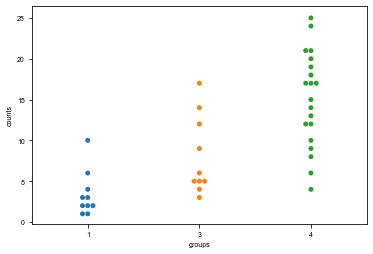

In [19]:
groupsToKeep = ["1", "3", "4"]
dfKeep = df.loc[df['groups'].isin(groupsToKeep)]

# Use general df variable to ease the plotting
df = dfKeep
df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + datasetPrefix + '-bud-count.csv')

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


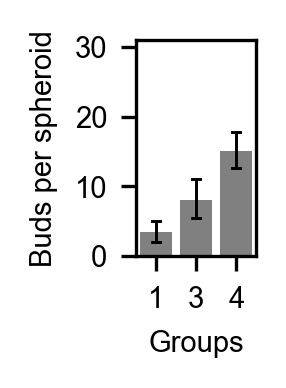

In [20]:
# Plot the bar graph to put in figures
outputPrefix = "20200120-6dpt-integrin-activation-MnCl2"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=31, yTicks=[0,10,20,30], fig_width=0.5, fig_height=0.9)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2     5.55 0.2186  -1.978  13.078  False
     1      3     10.8 0.0092  2.1074 19.4926   True
     1      4     26.4  0.001  18.872  33.928   True
     2      3     5.25 0.2629  -2.278  12.778  False
     2      4    20.85  0.001 14.7034 26.9966   True
     3      4     15.6  0.001   8.072  23.128   True
----------------------------------------------------
p values of all pair-wise tests:
 [0.2186398  0.00915167 0.001      0.26292699 0.001      0.001     ]


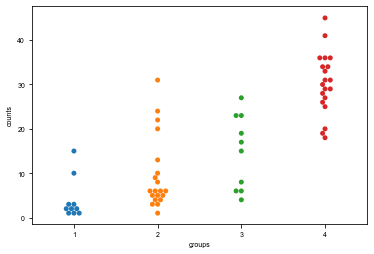

In [21]:
# Read in the data and put into a data frame
datasetPrefix = "20200122-8dpt-integrin-activation-MnCl2"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# The layout of this data set is straightforward.
#
# Group 1, B2-B11: sg-Control only
# Group 2, C2-D11: sg-Control only, 50 uM MnCl2
# Group 3, E2-E11: sg-Control mixed with sg2-Ecad (4:1)
# Group 4, F2-G6: sg-Control mixed with sg2-Ecad (4:1), 50 uM MnCl2

groups = ["1"]*10 + ["2"]*20 + ["3"]*10 + ["4"]*20
df["groups"] = groups

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      3     10.8 0.0032  3.321 18.279   True
     1      4     26.4  0.001 19.923 32.877   True
     3      4     15.6  0.001  9.123 22.077   True
--------------------------------------------------
p values of all pair-wise tests:
 [0.00321349 0.001      0.001     ]


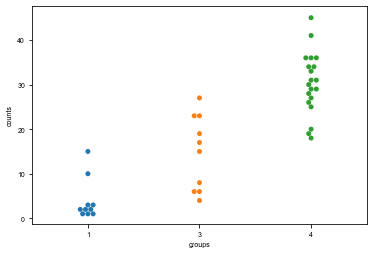

In [22]:
groupsToKeep = ["1", "3", "4"]
dfKeep = df.loc[df['groups'].isin(groupsToKeep)]

# Use general df variable to ease the plotting
df = dfKeep
df['data_to_compare'] = df.counts
df.to_csv('../data_cleaned/' + datasetPrefix + '-bud-count.csv')

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


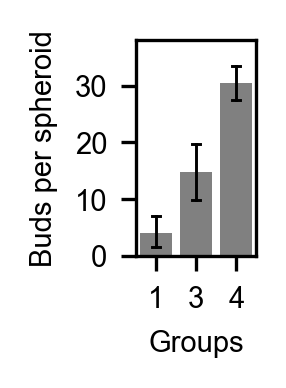

In [23]:
# Plot the bar graph to put in figures
outputPrefix = "20200122-8dpt-integrin-activation-MnCl2"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath, yMax=38, yTicks=[0,10,20,30], fig_width=0.5, fig_height=0.9)


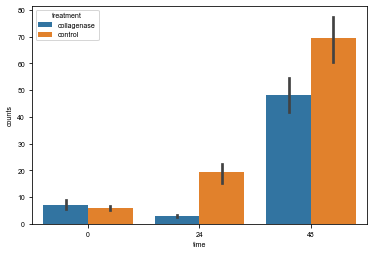

In [24]:
# Read in the data and put into a data frame
datasetPrefix = "20200117-0119-collagenase-recovery-tifs"
df = getCountDFbyPrefix(datasetPrefix, datasetFolder='../data/SMG-collagenase-recovery-bud-count-SW/')

# Annotate the data set
#
# Group 1: time 0 of collagenase treatment and recovery group
# Group 2: time 0 of control group
# Group 3: time 24 h of collagenase treatment and recovery group
# Group 4, time 24 h of control group
# Group 5: time 48 h of collagenase treatment and recovery group
# Group 6, time 48 h of control group
groups = ["1"]*11 + ["2"]*11 + ["3"]*11 + ["4"]*11 + ["5"]*11 + ["6"]*11
df["groups"] = groups

# Groups of treatment
treatment = ["collagenase"]*11 + ["control"]*11 + ["collagenase"]*11 + ["control"]*11 + ["collagenase"]*11 + ["control"]*11
df["treatment"] = treatment

# Time points:
time = [0]*22 + [24]*22 + [48]*22
df["time"] = time

df.shape
df.head()

# # Inspect raw data if curious about how they look
# sns.swarmplot(df.groups, df.counts)
# sns.swarmplot(x='time', y='counts', hue='treatment', data=df)
sns.barplot(x='time', y='counts', hue='treatment', data=df)


In [25]:
# Normalize data by dividing the counts by the time 0 counts for plotting
counts_t0 = df.counts.values[:22]
print(counts_t0)
counts_t24 = df.counts.values[22:44]
print(counts_t24)
df['ratio_of_counts'] = df.counts / np.concatenate([counts_t0, counts_t0, counts_t24])
df['log2ratio_of_counts'] = np.log2(df.ratio_of_counts)
df.head()


[ 8  3  4  7 10  9  8  3  5 13  7  5  6  5  6  7  9  6  4  5  7  6]
[ 3  2  2  4  3  4  2  2  2  4  3 24 24 12 21 25 22 21  6 22 23 13]
2020-04-16 09:24:59,254 - INFO - NumExpr defaulting to 8 threads.


,file_name,scrambled_file_name,counts,groups,treatment,time,ratio_of_counts,log2ratio_of_counts
0,2020-01-17-collagenase-recovery-collagenase20-...,fb7a7b561c6cc4050adf761be6e9a164.tif,8,1,collagenase,0,1.0,0.0
1,2020-01-17-collagenase-recovery-collagenase20-...,d3fda32d683844d50390208c78e1f225.tif,3,1,collagenase,0,1.0,0.0
2,2020-01-17-collagenase-recovery-collagenase20-...,1462cc3b204becb43eeaab1d4740d5e7.tif,4,1,collagenase,0,1.0,0.0
3,2020-01-17-collagenase-recovery-collagenase20-...,b21ba2f7e1b168a4f1b69f9fb89a542a.tif,7,1,collagenase,0,1.0,0.0
4,2020-01-17-collagenase-recovery-collagenase20-...,3a4709d440dcdf17f67ce645bf086547.tif,10,1,collagenase,0,1.0,0.0


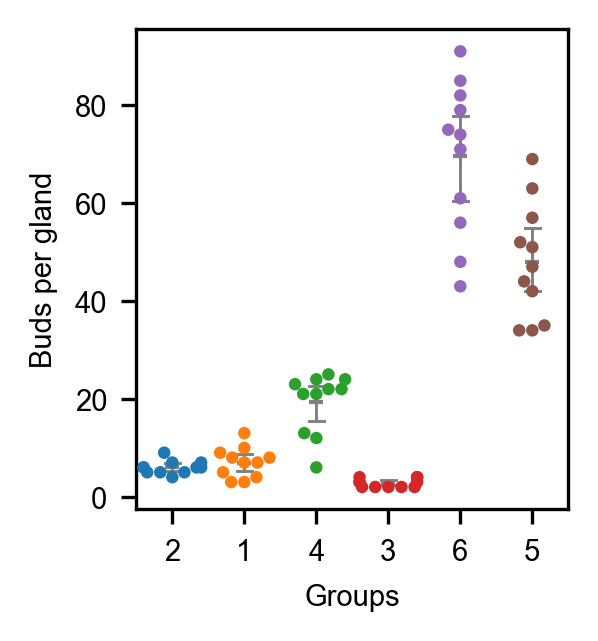

In [26]:
# Make swarm plot with error bars for the raw counts

fig_width, fig_height = 1.8, 2.0
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='groups', y='counts', data=df, size=3, order=['2', '1', '4', '3', '6', '5'])
ax = sns.pointplot(x='groups', y='counts', data=df, order=['2', '1', '4', '3', '6', '5'],
                   ci=95, capsize=.2, errwidth=.7,
                   markers='_', scale=.5, join=False, color="Gray")

plt.xlabel("Groups")
plt.ylabel("Buds per gland")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

outputFigPath = '../jupyter_figures/' + datasetPrefix + '-bud-count-v0415.svg'
plt.savefig(outputFigPath)


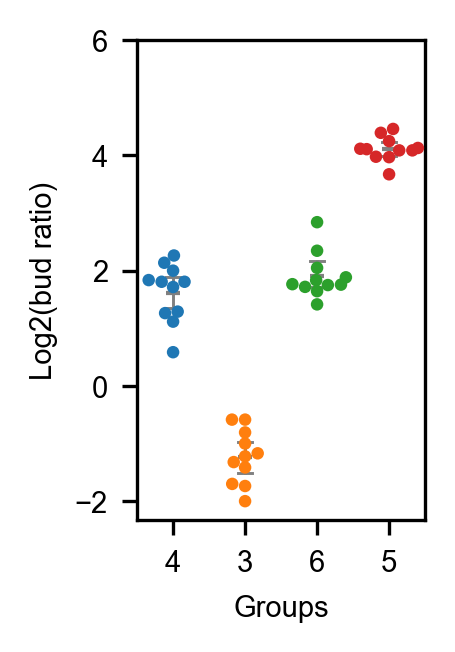

In [27]:
# Make swarm plot with error bars for the log2 ratio of counts

fig_width, fig_height = 1.2, 2.0
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='groups', y='log2ratio_of_counts', data=df, size=3, order=['4', '3', '6', '5'])
ax = sns.pointplot(x='groups', y='log2ratio_of_counts', data=df, order=['4', '3', '6', '5'],
                   ci=95, capsize=.2, errwidth=.7,
                   markers='_', scale=.5, join=False, color="Gray")

plt.xlabel("Groups")
plt.ylabel("Log2(bud ratio)")
ax.set_yticks([-2, 0, 2, 4, 6])

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

outputFigPath = '../jupyter_figures/' + datasetPrefix + '-log2-ratio-of-counts-v0415.svg'
plt.savefig(outputFigPath)


In [28]:
# # Perform a Tukey test of counts across all groups
tukeyTest(df.counts, df.groups)

# # Perform a Tukey test of log2 ratio of counts across 24h and 48h groups
tukeyTest(df.log2ratio_of_counts[22:], df.groups[22:])


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     -1.0    0.9  -11.637   9.637  False
     1      3  -4.1818 0.8387 -14.8189  6.4552  False
     1      4  12.3636 0.0137   1.7266 23.0007   True
     1      5     41.0  0.001   30.363  51.637   True
     1      6  62.5455  0.001  51.9084 73.1825   True
     2      3  -3.1818    0.9 -13.8189  7.4552  False
     2      4  13.3636  0.006   2.7266 24.0007   True
     2      5     42.0  0.001   31.363  52.637   True
     2      6  63.5455  0.001  52.9084 74.1825   True
     3      4  16.5455  0.001   5.9084 27.1825   True
     3      5  45.1818  0.001  34.5448 55.8189   True
     3      6  66.7273  0.001  56.0902 77.3643   True
     4      5  28.6364  0.001  17.9993 39.2734   True
     4      6  50.1818  0.001  39.5448 60.8189   True
     5      6  21.5455  0.001  10.9084 32.1825   True
----------

In [7]:
# Bud count data for single bud culture from dissected E13 SMG epithelial rudiments

df = pd.read_csv('../data/bud-count-single-bud-single-cell-SMG-culture/20200917-E13epi-K14-RFP-single-bud-zStack-day1-budCount.txt')
df.columns = ['file_name', 'bud_count']
df['group'] = ['day1'] * len(df)
df1 = df

df = pd.read_csv('../data/bud-count-single-bud-single-cell-SMG-culture/20200918-E13epi-K14-RFP-single-bud-zStack-day2-budCount.txt')
df.columns = ['file_name', 'bud_count']
df['group'] = ['day2'] * len(df)
df2 = df

df = pd.concat([df1, df2])

In [8]:
df

,file_name,bud_count,group
0,01_01-MG.nd2,6,day1
1,02_02-MG.nd2,3,day1
2,03_03-MG.nd2,6,day1
3,04_04-MG.nd2,5,day1
4,05_05-MG.nd2,4,day1
5,06_06-MG.nd2,6,day1
6,07_07-MG.nd2,7,day1
7,08_08-MG.nd2,5,day1
0,01_01-MG.nd2,17,day2
1,02_02-MG.nd2,13,day2


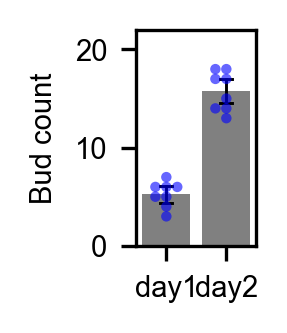

In [15]:
outputPrefix = '20200916-18-SMG-single-bud-culture-bud-count'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.5
fig_height=0.9
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='group', y='bud_count', data=df,
                   color="blue", size=2.5, alpha=.6)

ax = sns.barplot(x='group', y='bud_count', data=df,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 22)
plt.yticks([0, 10, 20])

plt.xlabel(None)
plt.ylabel("Bud count")

# ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [16]:
# Bud count data for single cell culture from dissected E13 SMG epithelial rudiments

df = pd.read_csv('../data/bud-count-single-bud-single-cell-SMG-culture/20200919-E13epi-K14-RFP-single-cell-unsorted-zStack-day1-budCount.txt')
df.columns = ['file_name', 'bud_count']
df['group'] = ['day1'] * len(df)
df1 = df

df = pd.read_csv('../data/bud-count-single-bud-single-cell-SMG-culture/20200920-E13epi-K14-RFP-single-cell-unsorted-zStack-day2-budCount.txt')
df.columns = ['file_name', 'bud_count']
df['group'] = ['day2'] * len(df)
df2 = df

df = pd.concat([df1, df2])
df

,file_name,bud_count,group
0,1.nd2,4,day1
1,2.nd2,4,day1
2,3.nd2,5,day1
3,4.nd2,6,day1
4,5.nd2,6,day1
0,1.nd2,15,day2
1,2.nd2,16,day2
2,3.nd2,14,day2
3,4.nd2,14,day2
4,5.nd2,16,day2


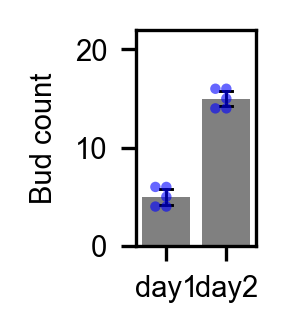

In [17]:
outputPrefix = '20200916-18-SMG-single-cell-culture-bud-count'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.5
fig_height=0.9
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x='group', y='bud_count', data=df,
                   color="blue", size=2.5, alpha=.6)

ax = sns.barplot(x='group', y='bud_count', data=df,
                 color="Gray", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 22)
plt.yticks([0, 10, 20])

plt.xlabel(None)
plt.ylabel("Bud count")

# ax.set_xticklabels(labels=plot_order, rotation=45, ha="right")

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [130]:
# This is the combination of 2 data sets of collagenase titration, 20200911-12 and 20200917-18
#
# Time 2 h
df = pd.read_csv('../data/SMG-collagenase-titration-bud-count-SW/20200911-17-E13-SMG-collagenase-titration-t2h-budCount.txt')
df1 = df[:-3] # only plot up to 2 ug/mL
# Time 24 h
df = pd.read_csv('../data/SMG-collagenase-titration-bud-count-SW/20200912-18-E13-SMG-collagenase-titration-t24-budCount.txt')
df2 = df[:-3] # only plot up to 2 ug/mL

# Designate experimental groups
# Groups 1-5: 0, 0.02, 0.2, 2 and 20 µg/mL collagenase for 24 hours
# groups = ['1'] * 5 + ['2'] * 5 + ['3'] * 6 + ['4'] * 3 + ['5'] * 3
groups = ['1'] * 5 + ['2'] * 5 + ['3'] * 6 + ['4'] * 3

# Calculate the bud count ratios
ratios = df2['number of buds'] / df1['number of buds']

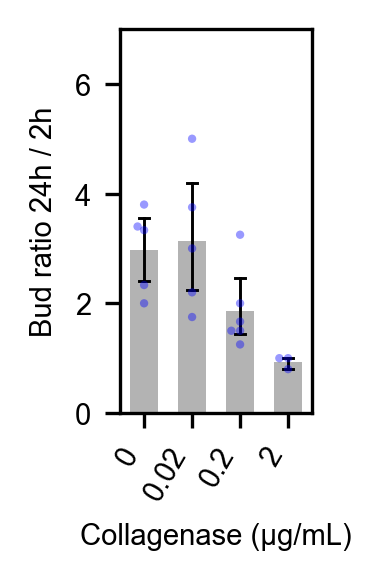

In [139]:
# Swarm and bar plot of different collagenase concentrations

outputPrefix = '20200911-17-SMG-collagenase-titration-swarm-bar'
outputFigPath = "../jupyter_figures/" + outputPrefix + ".svg"

fig_width=0.8
fig_height=1.6
fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax = sns.swarmplot(x=groups, y=ratios,
                   color="blue",
                   size=2.0,
                   alpha=.4)

ax = sns.barplot(x=groups, y=ratios,
                 color=".7", alpha=1.0,
                 errwidth=.7, errcolor="k", capsize=.2, ci=95)

plt.ylim(0, 7)
# plt.yticks([0, 10, 20])

plt.xlabel("Collagenase (µg/mL)")
plt.ylabel("Bud ratio 24h / 2h")

# rotate x tick labels if necessary
x_labels = ['0', '0.02', '0.2', '2']
ax.set_xticklabels(labels=x_labels, rotation=60, ha="right")

# make the bar width narrower
change_bar_width(ax, .6)

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

if outputFigPath is not None:
    plt.savefig(outputFigPath)


In [132]:
tukeyTest(ratios, groups)

Summary of test:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.1667    0.9  -1.441  1.7743  False
     1      3  -1.1122 0.2033 -2.6514   0.427  False
     1      4    -2.04  0.029 -3.8963 -0.1837   True
     2      3  -1.2789 0.1211 -2.8181  0.2603  False
     2      4  -2.2067 0.0176  -4.063 -0.3503   True
     3      4  -0.9278 0.4694 -2.7252  0.8696  False
----------------------------------------------------
p values of all pair-wise tests:
 [0.9        0.20326579 0.02904626 0.1210723  0.01758085 0.46938882]


In [142]:
# Read in the data and put into a data frame
datasetPrefix = "20200909-6dpt-D193-D267-1to1-MG-LMN-mix-plate1"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# All spheroids were 1-to-1 mixture of D193 (sg-Control) and D267 (sg1-Ecad) cells
#
# Group 1, B2-B11: MG alone
# Group 2, C2-C11: 5 MG + 1 LMN
# Group 3, D2-D11: 2 MG + 1 LMN
# Group 4, D2-D11: 1 MG + 1 LMN
# Group 5, E2-E11: 1 MG + 2 LMN
# Group 6, E2-E11: 1 MG + 5 LMN
groups = ["1"]*10 + ["2"]*10 + ["3"]*10 + ["4"]*10 + ["5"]*10 + ["6"]*10
df["groups"] = groups

df1 = df


# Read in the data and put into a data frame
datasetPrefix = "20200909-6dpt-D193-D267-1to1-MG-LMN-mix-plate2-selected"
df = getCountDFbyPrefix(datasetPrefix)

# Annotate the data set
#
# All spheroids were 1-to-1 mixture of D193 (sg-Control) and D267 (sg1-Ecad) cells
#
# Group 1, B2-B11: LMN alone
# Group 2, C2-C11: MG alone (diluted from 9.7 mg/mL, rather than 6 mg/mL)

groups = ["7"]*10 + ["8"]*10
df["groups"] = groups

df2 = df


In [143]:
# Combine the data for plotting.
# Filter out the 10 spheroids in the second plate that uses different Matrigel stock.
df = pd.concat([df1, df2.iloc[:10, :]])
df.reset_index(inplace=True)

df
# # Inspect raw data if curious about how they look
# sns.swarmplot(df.groups, df.counts)

# # Perform a Tukey test across groups
# tukeyTest(df.counts, df.groups)


,index,file_name,scrambled_file_name,counts,groups
0,0,"Plate000_WellB02_ChannelMono,GFP,RFP_Seq0000.nd2",0a7f2b85856b838896920c032b5160db.nd2,9,1
1,1,"Plate000_WellB03_ChannelMono,GFP,RFP_Seq0001.nd2",eae2cf4d0a05e300e586916c4f7fa2c3.nd2,15,1
2,2,"Plate000_WellB04_ChannelMono,GFP,RFP_Seq0002.nd2",30aa897cd645456df633a9a99880504e.nd2,16,1
3,3,"Plate000_WellB05_ChannelMono,GFP,RFP_Seq0003.nd2",cd060b1e55f3c6da837db6df128ad4f7.nd2,16,1
4,4,"Plate000_WellB06_ChannelMono,GFP,RFP_Seq0004.nd2",5980a4022129b02be6773666687f4c1e.nd2,15,1
...,...,...,...,...,...
65,5,"Plate000_WellB07_ChannelMono,GFP,RFP_Seq0005.nd2",65cd9ac2946125592d8bfb2c72346466.nd2,2,7
66,6,"Plate000_WellB08_ChannelMono,GFP,RFP_Seq0006.nd2",d41a394699e4a508d59fbd3a78d079f2.nd2,4,7
67,7,"Plate000_WellB09_ChannelMono,GFP,RFP_Seq0007.nd2",9f7278d9d4f7c0bfefb866eaff1a1f84.nd2,1,7
68,8,"Plate000_WellB10_ChannelMono,GFP,RFP_Seq0008.nd2",8ad65f4689a0f0f2de3f1e81e67ad8f5.nd2,2,7


Summary of test:
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     -4.4 0.1044  -9.2845  0.4845  False
     1      3     -5.9 0.0084 -10.7845 -1.0155   True
     1      4     -7.4  0.001 -12.2845 -2.5155   True
     1      5     -9.1  0.001 -13.9845 -4.2155   True
     1      6     -9.4  0.001 -14.2845 -4.5155   True
     1      7    -11.3  0.001 -16.1845 -6.4155   True
     2      3     -1.5    0.9  -6.3845  3.3845  False
     2      4     -3.0 0.5057  -7.8845  1.8845  False
     2      5     -4.7  0.067  -9.5845  0.1845  False
     2      6     -5.0 0.0415  -9.8845 -0.1155   True
     2      7     -6.9 0.0011 -11.7845 -2.0155   True
     3      4     -1.5    0.9  -6.3845  3.3845  False
     3      5     -3.2 0.4301  -8.0845  1.6845  False
     3      6     -3.5 0.3196  -8.3845  1.3845  False
     3      7     -5.4  0.021 -10.2845 -0.5155   True
     4    

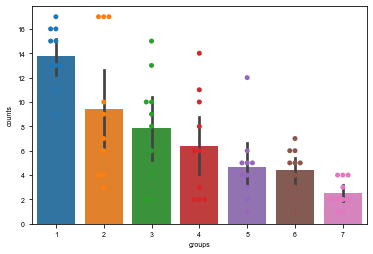

In [144]:
# bar plot of all groups
sns.barplot(df.groups, df.counts)

# Inspect raw data if curious about how they look
sns.swarmplot(df.groups, df.counts)

# Perform a Tukey test across groups
tukeyTest(df.counts, df.groups)


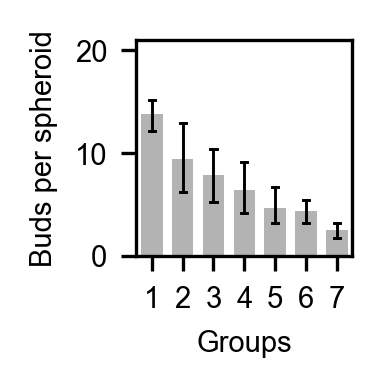

In [150]:
# Plot the bar graph to put in figures
outputPrefix = "20200909-6dpt-D193-D267-1to1-MG-LMN-mix"
outputFigPath = "../jupyter_figures/" + outputPrefix + "-bud-count.svg"
plotCountBar(df.groups, df.counts, outputFigPath,
             yMax=21, yTicks=[0,10,20],
             bar_width=0.7,
             fig_width=0.9, fig_height=0.9)
